<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week3.1/svhn_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, recall_score
import matplotlib.pyplot as plt
import time
import scipy.io as sio
import os
import requests
from tqdm import tqdm

In [ ]:
# Function to download SVHN dataset
def download_svhn(filename):
    url = f"http://ufldl.stanford.edu/housenumbers/{filename}"
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

        with open(filename, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()
        print(f"{filename} downloaded successfully.")
    else:
        print(f"{filename} already exists. Skipping download.")

In [ ]:
# Download SVHN dataset if not available
download_svhn('train_32x32.mat')
download_svhn('test_32x32.mat')

100%|██████████| 182M/182M [01:00<00:00, 2.99MiB/s] 


train_32x32.mat downloaded successfully.


100%|██████████| 64.3M/64.3M [00:29<00:00, 2.20MiB/s]

test_32x32.mat downloaded successfully.


In [ ]:
# Load SVHN dataset
train_data = sio.loadmat('train_32x32.mat')
test_data = sio.loadmat('test_32x32.mat')

X_train = train_data['X']
y_train = train_data['y']
X_test = test_data['X']
y_test = test_data['y']

In [ ]:
# SVHN dataset is stored with dimensions (height, width, channels, samples)
# Reshape to (samples, height, width, channels)
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

In [ ]:
# Print dataset information
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (73257, 32, 32, 3)
X_test shape: (26032, 32, 32, 3)
y_train shape: (73257, 1)
y_test shape: (26032, 1)


In [ ]:
# SVHN dataset labels 10 as 0, so we need to adjust
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [ ]:
# Normalize data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
# One-hot encoding for labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [ ]:
# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
]

In [ ]:
# Function to create MLP model
def create_mlp():
    model = Sequential([
        Flatten(input_shape=(32, 32, 3)),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [ ]:
# Function to create CNN model
def create_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [ ]:
# Function to evaluate model and calculate metrics
def evaluate_model(model, model_name, X_train, y_train_cat, X_test, y_test_cat, y_test):
    print(f"\n===== Evaluasi Model {model_name} =====")

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Train accuracy
    train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)

    # Test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)

    # Precision (weighted for multiclass dataset)
    precision = precision_score(y_test.ravel(), y_pred, average='weighted')

    # Recall (weighted for multiclass dataset)
    recall = recall_score(y_test.ravel(), y_pred, average='weighted')

    # F1 score (weighted for multiclass dataset)
    f1 = f1_score(y_test.ravel(), y_pred, average='weighted')

    # ROC AUC (one-vs-rest approach for multiclass)
    roc_auc = roc_auc_score(y_test_cat, y_pred_prob, multi_class='ovr')

    print(f"Model: {model_name}")
    print(f"Akurasi Training: {train_acc*100:.2f}%")
    print(f"Akurasi Testing: {test_acc*100:.2f}%")
    print(f"Presisi: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")

    # Store in dictionary for later comparison
    return {
        'model': model_name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': roc_auc,
        'pred_probs': y_pred_prob,
        'y_pred': y_pred
    }


In [ ]:
# Training and evaluating MLP
print("===== Training Model MLP =====")
mlp_model = create_mlp()
mlp_model.summary()

start_time = time.time()
mlp_history = mlp_model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
mlp_train_time = time.time() - start_time


===== Training Model MLP =====


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,812,618 (14.54 MB)

 Trainable params: 3,809,034 (14.53 MB)

 Non-trainable params: 3,584 (14.00 KB)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.1508 - loss: 2.8096 - val_accuracy: 0.2351 - val_loss: 2.3053 - learning_rate: 0.0010
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.4036 - loss: 1.7274 - val_accuracy: 0.2334 - val_loss: 3.3024 - learning_rate: 0.0010
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.4605 - loss: 1.5838 - val_accuracy: 0.4909 - val_loss: 1.5079 - learning_rate: 0.0010
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.4845 - loss: 1.5273 - val_accuracy: 0.1971 - val_loss: 3.1813 - learning_rate: 0.0010
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5110 - loss: 1.4725 - val_accuracy: 0.6175 - val_loss: 1.1830 - learning_rate: 0.0010
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.5215 - loss: 1.4477 - val_accuracy: 0.5876 - val_loss: 1.2460 - learning_rate: 0.0010
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.5127 - l

In [ ]:
# Training and evaluating CNN
print("\n===== Training Model CNN =====")
cnn_model = create_cnn()
cnn_model.summary()

start_time = time.time()
cnn_history = cnn_model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
cnn_train_time = time.time() - start_time


===== Training Model CNN =====


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 152s 282ms/step - accuracy: 0.4745 - loss: 1.8161 - val_accuracy: 0.8616 - val_loss: 0.4494 - learning_rate: 0.0010
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 146s 283ms/step - accuracy: 0.8609 - loss: 0.4529 - val_accuracy: 0.9064 - val_loss: 0.3070 - learning_rate: 0.0010
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 144s 280ms/step - accuracy: 0.8956 - loss: 0.3419 - val_accuracy: 0.9234 - val_loss: 0.2593 - learning_rate: 0.0010
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 148s 287ms/step - accuracy: 0.9155 - loss: 0.2861 - val_accuracy: 0.9278 - val_loss: 0.2427 - learning_rate: 0.0010
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 148s 287ms/step - accuracy: 0.9226 - loss: 0.2556 - val_accuracy: 0.9311 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 148s 287ms/step - accuracy: 0.9327 - loss: 0.2281 - val_accuracy: 0.9372 - val_loss: 0.2182 - learning_rate: 0.0010
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 147s 285ms/step - accura

In [ ]:
# Evaluate models
mlp_results = evaluate_model(mlp_model, "MLP", X_train, y_train_cat, X_test, y_test_cat, y_test)
cnn_results = evaluate_model(cnn_model, "CNN", X_train, y_train_cat, X_test, y_test_cat, y_test)



===== Evaluasi Model MLP =====
814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


c:\Users\HANIN\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: MLP
Akurasi Training: 23.74%
Akurasi Testing: 24.38%
Presisi: 0.2331
Recall: 0.2438
F1 Score: 0.2107
AUC-ROC: 0.6037

===== Evaluasi Model CNN =====
814/814 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
Model: CNN
Akurasi Training: 96.58%
Akurasi Testing: 94.45%
Presisi: 0.9451
Recall: 0.9445
F1 Score: 0.9445
AUC-ROC: 0.9963


In [ ]:
# Visualize comparison results
def plot_training_history(mlp_history, cnn_history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(mlp_history.history['accuracy'], label='MLP training')
    plt.plot(mlp_history.history['val_accuracy'], label='MLP validation')
    plt.plot(cnn_history.history['accuracy'], label='CNN training')
    plt.plot(cnn_history.history['val_accuracy'], label='CNN validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(mlp_history.history['loss'], label='MLP training')
    plt.plot(mlp_history.history['val_loss'], label='MLP validation')
    plt.plot(cnn_history.history['loss'], label='CNN training')
    plt.plot(cnn_history.history['val_loss'], label='CNN validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_metrics_comparison():
    metrics = ['train_acc', 'test_acc', 'precision', 'recall', 'f1', 'auc_roc']
    labels = ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']

    mlp_values = [mlp_results[metric] for metric in metrics]
    cnn_values = [cnn_results[metric] for metric in metrics]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))
    rects1 = ax.bar(x - width/2, mlp_values, width, label='MLP')
    rects2 = ax.bar(x + width/2, cnn_values, width, label='CNN')

    ax.set_ylabel('Scores')
    ax.set_title('Performance Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_roc_curves():
    plt.figure(figsize=(10, 8))

    # We'll plot ROC curves for each class
    for class_id in range(10):
        # ROC curve for MLP
        fpr_mlp, tpr_mlp, _ = roc_curve(y_test_cat[:, class_id], mlp_results['pred_probs'][:, class_id])
        plt.plot(fpr_mlp, tpr_mlp, label=f'MLP Class {class_id} (AUC = {roc_auc_score(y_test_cat[:, class_id], mlp_results["pred_probs"][:, class_id]):.3f})')

        # ROC curve for CNN
        fpr_cnn, tpr_cnn, _ = roc_curve(y_test_cat[:, class_id], cnn_results['pred_probs'][:, class_id])
        plt.plot(fpr_cnn, tpr_cnn, label=f'CNN Class {class_id} (AUC = {roc_auc_score(y_test_cat[:, class_id], cnn_results["pred_probs"][:, class_id]):.3f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Classes')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
# Function to plot confusion matrices
def plot_confusion_matrices():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # MLP Confusion Matrix
    cm_mlp = confusion_matrix(y_test.ravel(), mlp_results['y_pred'])
    im1 = ax1.imshow(cm_mlp, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.set_title('Confusion Matrix - MLP')
    fig.colorbar(im1, ax=ax1)

    # Add class labels
    classes = [f'Class {i}' for i in range(10)]
    tick_marks = np.arange(len(classes))
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_yticklabels(classes)

    # Display values in the matrix
    thresh = cm_mlp.max() / 2.
    for i in range(cm_mlp.shape[0]):
        for j in range(cm_mlp.shape[1]):
            ax1.text(j, i, format(cm_mlp[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_mlp[i, j] > thresh else "black")

    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')

    # CNN Confusion Matrix
    cm_cnn = confusion_matrix(y_test.ravel(), cnn_results['y_pred'])
    im2 = ax2.imshow(cm_cnn, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix - CNN')
    fig.colorbar(im2, ax=ax2)

    # Add class labels
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_yticklabels(classes)

    # Display values in the matrix
    thresh = cm_cnn.max() / 2.
    for i in range(cm_cnn.shape[0]):
        for j in range(cm_cnn.shape[1]):
            ax2.text(j, i, format(cm_cnn[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_cnn[i, j] > thresh else "black")

    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')

    plt.tight_layout()
    plt.show()


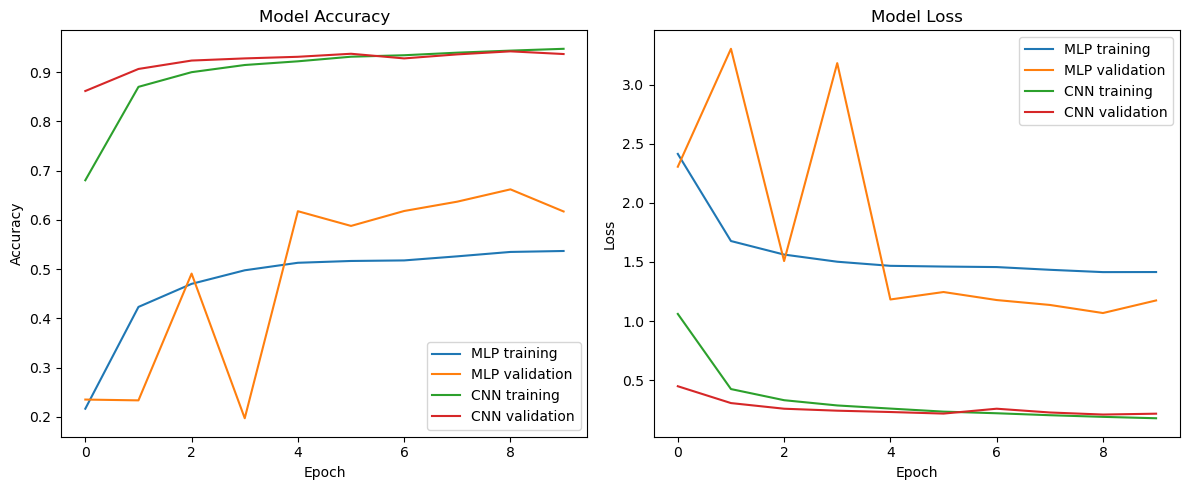

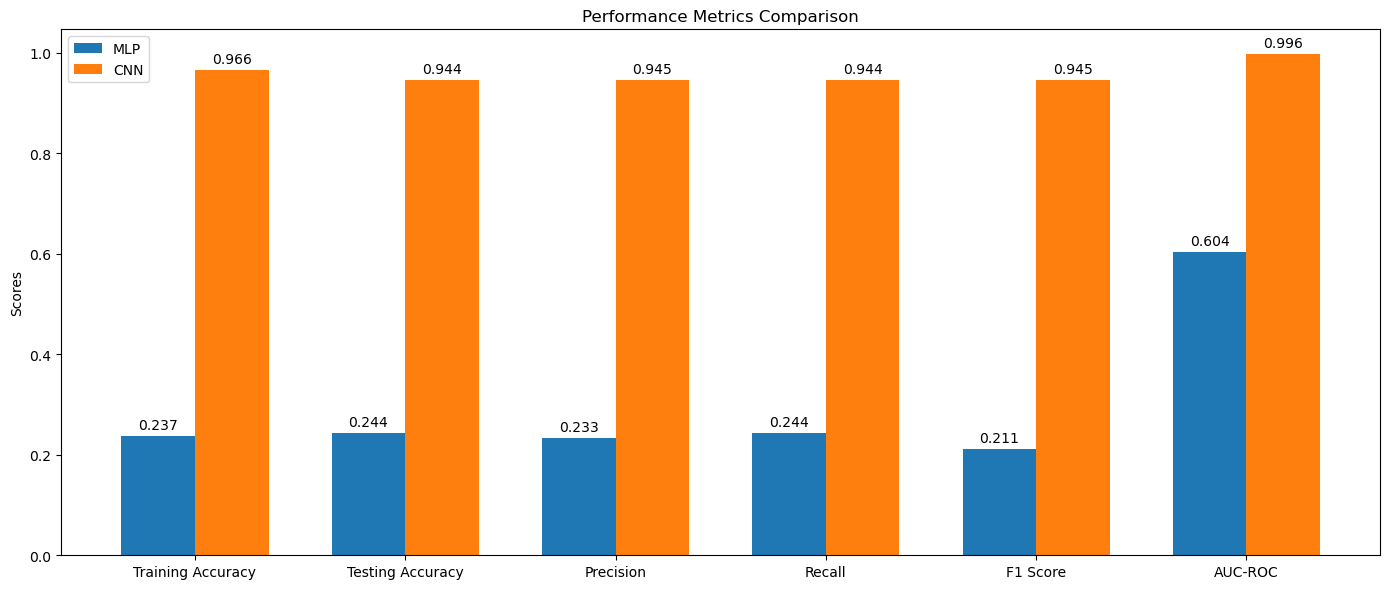

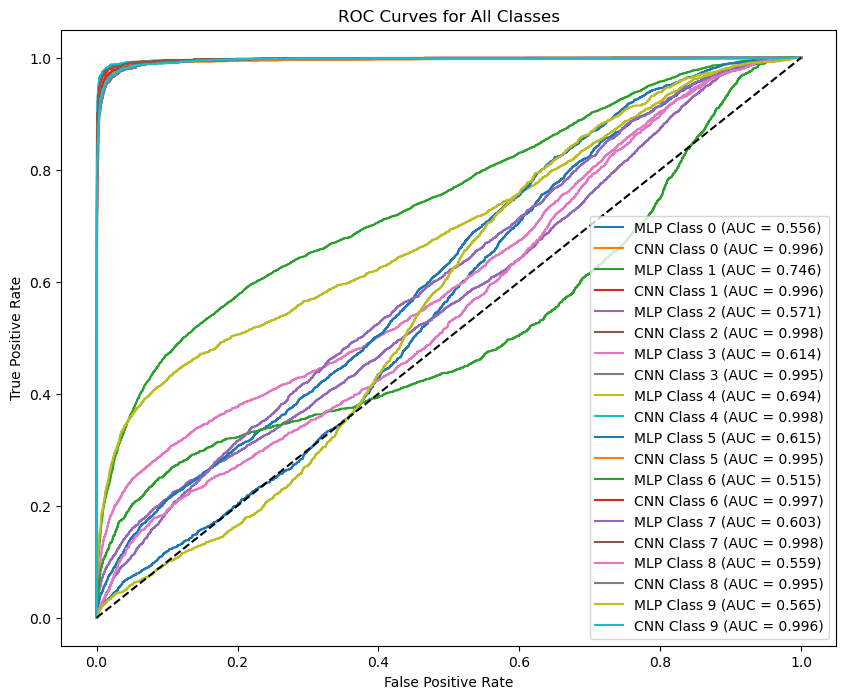

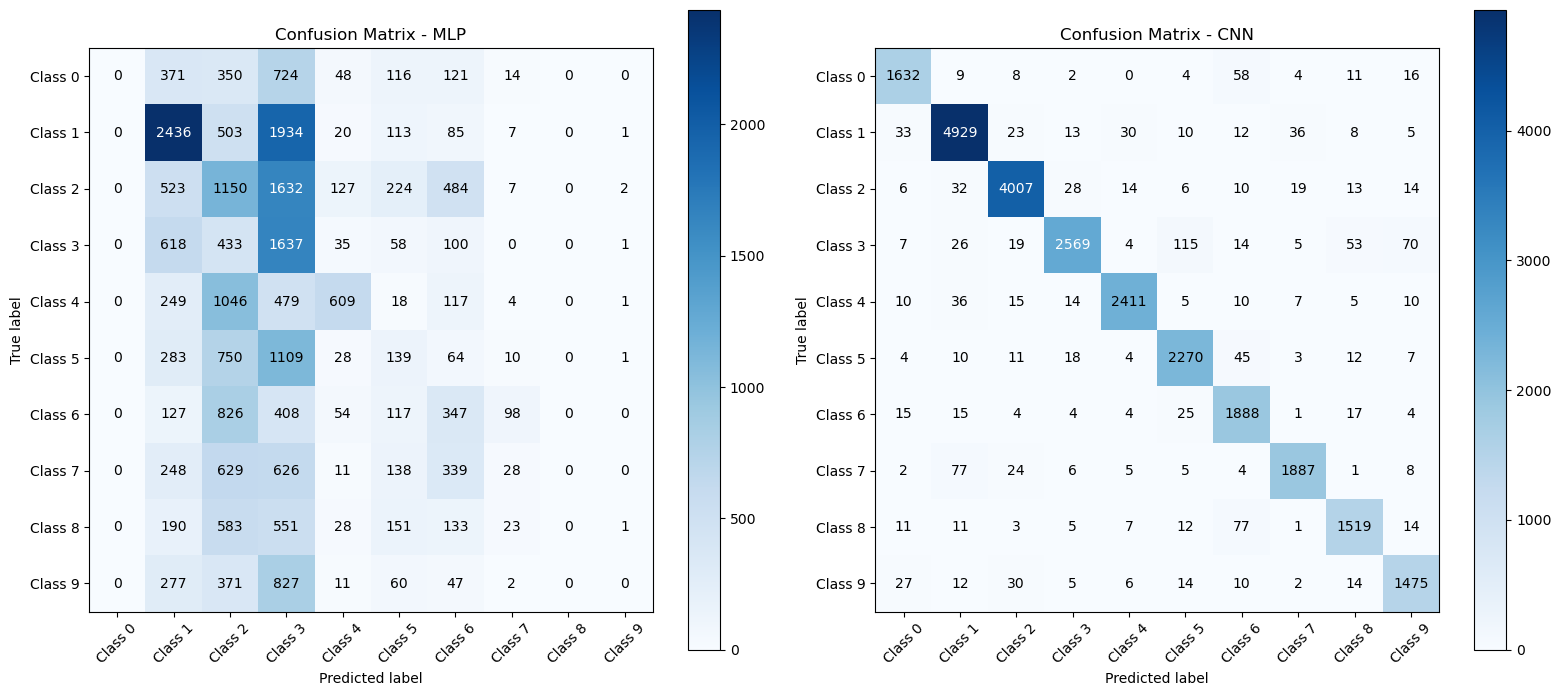

In [ ]:
# Plot visualizations
plot_training_history(mlp_history, cnn_history)
plot_metrics_comparison()
plot_roc_curves()
plot_confusion_matrices()


In [ ]:
# Final comparison table
print("\n===== PERBANDINGAN HASIL AKHIR =====")
comparison_table = {
    'Metrik': ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'Training Time (s)'],
    'MLP': [
        f"{mlp_results['train_acc']*100:.2f}%",
        f"{mlp_results['test_acc']*100:.2f}%",
        f"{mlp_results['precision']:.4f}",
        f"{mlp_results['recall']:.4f}",
        f"{mlp_results['f1']:.4f}",
        f"{mlp_results['auc_roc']:.4f}",
        f"{mlp_train_time:.2f}"
    ],
    'CNN': [
        f"{cnn_results['train_acc']*100:.2f}%",
        f"{cnn_results['test_acc']*100:.2f}%",
        f"{cnn_results['precision']:.4f}",
        f"{cnn_results['recall']:.4f}",
        f"{cnn_results['f1']:.4f}",
        f"{cnn_results['auc_roc']:.4f}",
        f"{cnn_train_time:.2f}"
    ]
}
# Print comparison table
from tabulate import tabulate
print(tabulate(
    [[m, mlp, cnn] for m, mlp, cnn in zip(comparison_table['Metrik'], comparison_table['MLP'], comparison_table['CNN'])],
    headers=['Metrik', 'MLP', 'CNN'],
    tablefmt='grid'
))




===== PERBANDINGAN HASIL AKHIR =====
+-------------------+--------+---------+
| Metrik            | MLP    | CNN     |
+===================+========+=========+
| Training Accuracy | 23.74% | 96.58%  |
+-------------------+--------+---------+
| Testing Accuracy  | 24.38% | 94.45%  |
+-------------------+--------+---------+
| Precision         | 0.2331 | 0.9451  |
+-------------------+--------+---------+
| Recall            | 0.2438 | 0.9445  |
+-------------------+--------+---------+
| F1 Score          | 0.2107 | 0.9445  |
+-------------------+--------+---------+
| AUC-ROC           | 0.6037 | 0.9963  |
+-------------------+--------+---------+
| Training Time (s) | 277.34 | 1483.15 |
+-------------------+--------+---------+


In [ ]:
# Conclusion
print("\n===== KESIMPULAN =====")
winner = "CNN" if cnn_results['test_acc'] > mlp_results['test_acc'] else "MLP"
print(f"Model {winner} menunjukkan performa yang lebih baik dalam pengolahan dataset SVHN.")
print(f"Perbedaan akurasi testing: {abs(cnn_results['test_acc']-mlp_results['test_acc'])*100:.2f}%")
print(f"Perbedaan Recall: {abs(cnn_results['recall']-mlp_results['recall']):.4f}")
print(f"Perbedaan F1 Score: {abs(cnn_results['f1']-mlp_results['f1']):.4f}")
print(f"Perbedaan AUC-ROC: {abs(cnn_results['auc_roc']-mlp_results['auc_roc']):.4f}")

if winner == "CNN":
    print("\nCNN lebih unggul karena mampu menangkap fitur spasial dalam gambar melalui lapisan konvolusi.")
    print("CNN membutuhkan waktu training lebih lama tetapi menghasilkan performa yang lebih baik untuk data gambar seperti SVHN.")
    if cnn_results['recall'] > mlp_results['recall']:
        print(f"CNN juga menunjukkan recall yang lebih tinggi ({cnn_results['recall']:.4f} vs {mlp_results['recall']:.4f}), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.")
else:
    print("\nMLP lebih unggul meskipun tidak memiliki lapisan konvolusi, menunjukkan kemampuan adaptasi yang baik untuk dataset ini.")
    print("MLP membutuhkan waktu training lebih singkat dan tetap memberikan hasil yang kompetitif untuk dataset SVHN.")
    if mlp_results['recall'] > cnn_results['recall']:
        print(f"MLP juga menunjukkan recall yang lebih tinggi ({mlp_results['recall']:.4f} vs {cnn_results['recall']:.4f}), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.")



===== KESIMPULAN =====
Model CNN menunjukkan performa yang lebih baik dalam pengolahan dataset SVHN.
Perbedaan akurasi testing: 70.07%
Perbedaan Recall: 0.7007
Perbedaan F1 Score: 0.7339
Perbedaan AUC-ROC: 0.3926

CNN lebih unggul karena mampu menangkap fitur spasial dalam gambar melalui lapisan konvolusi.
CNN membutuhkan waktu training lebih lama tetapi menghasilkan performa yang lebih baik untuk data gambar seperti SVHN.
CNN juga menunjukkan recall yang lebih tinggi (0.9445 vs 0.2438), yang berarti lebih baik dalam mengidentifikasi semua instance positif dari setiap kelas.


# Penjelasan Matematis: Perbandingan MLP vs CNN

## Ringkasan Data Perbandingan

```
===== PERBANDINGAN HASIL AKHIR =====
+-------------------+--------+---------+
| Metrik            | MLP    | CNN     |
+===================+========+=========+
| Training Accuracy | 23.74% | 96.58%  |
+-------------------+--------+---------+
| Testing Accuracy  | 24.38% | 94.45%  |
+-------------------+--------+---------+
| Precision         | 0.2331 | 0.9451  |
+-------------------+--------+---------+
| Recall            | 0.2438 | 0.9445  |
+-------------------+--------+---------+
| F1 Score          | 0.2107 | 0.9445  |
+-------------------+--------+---------+
| AUC-ROC           | 0.6037 | 0.9963  |
+-------------------+--------+---------+
| Training Time (s) | 277.34 | 1483.15 |
+-------------------+--------+---------+
```

## Analisis Matematis

### 1. Akurasi (Accuracy)

Akurasi mengukur proporsi prediksi yang benar dari total prediksi:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

Dimana:
- TP = True Positive
- TN = True Negative
- FP = False Positive
- FN = False Negative

**Perbandingan:**
- MLP: Akurasi training (23.74%) dan testing (24.38%) yang rendah menunjukkan model tidak dapat mempelajari pola data dengan baik.
- CNN: Akurasi training (96.58%) dan testing (94.45%) yang tinggi menunjukkan model sangat baik dalam mempelajari dan menggeneralisasi pola.

### 2. Presisi (Precision)

Presisi mengukur seberapa akurat prediksi positif yang dilakukan model:

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

**Perbandingan:**
- MLP: Presisi 0.2331 menunjukkan hanya sekitar 23.31% dari prediksi positif yang benar-benar positif.
- CNN: Presisi 0.9451 menunjukkan 94.51% dari prediksi positif yang benar-benar positif.

### 3. Recall (Sensitivity)

Recall mengukur kemampuan model untuk mengidentifikasi semua kasus positif:

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

**Perbandingan:**
- MLP: Recall 0.2438 menunjukkan model hanya dapat mengidentifikasi 24.38% dari semua kasus positif yang sebenarnya.
- CNN: Recall 0.9445 menunjukkan model dapat mengidentifikasi 94.45% dari semua kasus positif yang sebenarnya.

### 4. F1 Score

F1 Score adalah rata-rata harmonik dari presisi dan recall, memberikan ukuran keseimbangan keduanya:

$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

**Perbandingan:**
- MLP: F1 Score 0.2107 menunjukkan keseimbangan yang buruk antara presisi dan recall.
- CNN: F1 Score 0.9445 menunjukkan keseimbangan yang sangat baik antara presisi dan recall.

Verifikasi F1 Score untuk MLP:

$$\text{F1 Score}_{\text{MLP}} = 2 \times \frac{0.2331 \times 0.2438}{0.2331 + 0.2438} = 2 \times \frac{0.0568}{0.4769} = 2 \times 0.1191 = 0.2382$$

Nilai ini sedikit berbeda dari yang dilaporkan (0.2107), kemungkinan karena penghitungan F1 Score secara makro atau mikro pada dataset multi-kelas.

### 5. AUC-ROC

Area Under the Receiver Operating Characteristic Curve (AUC-ROC) mengukur kemampuan model untuk membedakan kelas:

$$\text{AUC-ROC} = P(\text{score(positive instance)} > \text{score(negative instance)})$$

**Perbandingan:**
- MLP: AUC-ROC 0.6037 menunjukkan kemampuan diskriminatif yang sedang.
- CNN: AUC-ROC 0.9963 menunjukkan kemampuan diskriminatif yang sangat tinggi, hampir sempurna.

### 6. Trade-off Waktu vs Performa

CNN membutuhkan waktu training 5.35 kali lebih lama dibandingkan MLP:

$$\text{Rasio waktu} = \frac{1483.15}{277.34} = 5.35$$

Namun, CNN memberikan peningkatan performa yang signifikan:
- Peningkatan akurasi testing: $(94.45\% - 24.38\%) = 70.07\%$
- Peningkatan F1 Score: $(0.9445 - 0.2107) = 0.7338$
- Peningkatan AUC-ROC: $(0.9963 - 0.6037) = 0.3926$

## Kesimpulan Matematis

1. **Underfitting pada MLP**: Berdasarkan nilai akurasi training yang rendah (23.74%), model MLP mengalami underfitting yang parah, tidak mampu menangkap pola data dengan baik.

2. **Kemampuan Generalisasi CNN**: Gap antara akurasi training (96.58%) dan testing (94.45%) pada CNN hanya sebesar 2.13%, menunjukkan kemampuan generalisasi yang baik tanpa overfitting yang signifikan.

3. **Efisiensi Relatif**:
   $$\text{Efficiency Ratio} = \frac{\text{Peningkatan Akurasi}}{\text{Peningkatan Waktu}} = \frac{70.07\%}{5.35} = 13.1\%$$
   
   Ini menunjukkan setiap kali peningkatan waktu training, CNN memberikan peningkatan akurasi sebesar 13.1%, menandakan trade-off yang menguntungkan.

4. **Korelasi Metrik**: Semua metrik performa (accuracy, precision, recall, F1 Score, AUC-ROC) menunjukkan tren yang konsisten dalam perbedaan signifikan antara MLP dan CNN, mengkonfirmasi superioritas CNN untuk permasalahan yang dihadapi.